In [ ]:
"""
data_explore_on_mothers

The notebook is used to explore the extracted original data before processing it.
"""

In [288]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [287]:
bath_path = r'X:/SCS/04_Results/data_explore/'

# 1. Meta data
- region-USCI (Some codes do not match the 2020 area codes）
- delete useless columns

In [91]:
# load region code
region_path = r'X:/SCS/04_Results/data/regions.xlsx'
df_region = pd.read_excel(region_path, dtype={'code': str})

In [184]:
# load data from original dataset
m_path = r'X:/SCS/04_Results/data/mothers_original.xlsx'

df_meta_m = pd.read_excel(m_path, sheet_name='metadata')

In [98]:
# get level province region info from UCSI
# TODO : check县
def extract_usci(row):
    code6 = row['统一社会信用代码 Unified Social Credit Identifier, USCI'][2:8]
    level = region = province = ''
    
    try:
        # code match
        s = df_region[df_region['code'] == code6]
        region = s.iloc[0, 2]
        level = s.iloc[0, 1]
        province = df_region[df_region['code'] == (code6[:2] + '0000')].iloc[0, 2]
        return level, region, province
    except:
        # code unmatch， no region
        address = row['住所 Address']
        
        # set level by counting 0
        if code6[2:] == '0000':
            # province level
            level = '省'
        elif code6[4:] == '00':
            # city level
            level = '省市'
        else:
            # region level
            level = '省市区'
            
        # set province
        if level == '省':
            # definately no match， try to extract from address
            pos = address.find('省')+1
            if not pos:
                pos = address.find('市')+1
            province = region = address[0: pos]
            
        else:
            # try to match province
            province = df_region[df_region['code'] == (code6[:2] + '0000')].iloc[0, 2]
            # set pos, then extract region
            if level == '省市':
                pos = address.find('市') + 1
            else:
                pos = address.find('区') + 1
                if not pos:
                    pos = address.find('市') + 1
                if not pos:
                    pos = address.find('县') + 1
            region = address[0: pos]
        #print(level, region, province, address)
        return level, region, province
        


In [185]:
# add region info
df_meta_m[['level', 'region', 'province']] = df_meta_m.apply(extract_usci, axis=1, result_type='expand')

# delete 0 number columns 
df_meta_m.drop(['司法判决 Judicial decision', '信用评价 Credit assessment', '其他信息 Other information'], axis=1, inplace=True)
df_meta_m.head()

,"统一社会信用代码 Unified Social Credit Identifier, USCI",机构名称 Institution name,企业类型 Corporate type,住所 Address,法定代表/负责人/执行事务合伙人 Legal representative/Person in charge/Executive business partner,成立日期 Date of Foundation,行政管理 Administrative management,严重失信主体名单 Severe untrustworthy entity list,信用承诺 Credit commitment,诚实守信 Honesty and trustworthy,经营异常 Abnormal operation,black,green,red,event_count,n_pages,M_D,level,region,province
0,91441300195971850Y,TCL科技集团股份有限公司,其他股份有限公司(上市),广东省惠州仲恺高新区惠风三路17号TCL科技大厦,李东生,1982-03-11,8,0,0,5,0,0,1,1,13,9,M,省市,广东省惠州市,广东省
1,914400007361542488,一品红药业股份有限公司,其他股份有限公司(上市),广州市黄埔区广州国际生物岛寰宇一路27号云润大厦17层,李捍雄,2002-02-04,1,0,0,0,0,0,1,0,1,5,M,省,广东省,广东省
2,91440300192181490G,万科企业股份有限公司,股份有限公司(上市),深圳市盐田区大梅沙环梅路33号万科中心,郁亮,1984-05-30,30,0,4,4,0,0,1,1,38,24,M,省市,广东省深圳市,广东省
3,913100006073563962,上海大名城企业股份有限公司,股份有限公司(中外合资、上市),上海市闵行区红松东路1116号1幢5楼A区,俞锦,1996-07-18,2,0,0,2,0,0,1,1,4,5,M,省,上海市,上海市
4,914201007819530811,华灿光电股份有限公司,股份有限公司(台港澳与境内合资_x000D_、上市),武汉市东湖开发区滨湖路8号,郭瑾,2005-11-08,7,0,1,3,0,0,1,1,11,9,M,省市,湖北省武汉市,湖北省


# 2. Split events to sub-events

In [107]:
# load original events
df_event1_m = pd.read_excel(m_path, sheet_name='event1')
df_event2_m = pd.read_excel(m_path, sheet_name='event2')
df_event3_m = pd.read_excel(m_path, sheet_name='event3')
df_event4_m = pd.read_excel(m_path, sheet_name='event4')
df_event5_m = pd.read_excel(m_path, sheet_name='event5')
#df_event6_m = pd.read_excel(m_path, sheet_name='event6')

In [124]:
# the function is for checking if the sub-events are splited correctly
def check_equal(df_event, bool_list):
    sub_sum = sum([l.sum() for l in bool_list])
    total = df_event.shape[0]
    print(f'the number of sub events:{sub_sum}')
    print(f'total number: {total}')
    
    equal = total - sub_sum
    if equal == 0:
        print('Correct')
    else:
        print('Incorrect, please check the numbers of sub-events')
        for l in bool_list:
            print(l.sum())

## 2.1 split event1

In [116]:
# filter condition to get sub-events
bool_event_permit_old = df_event1_m['审核类型 Audit Type'].notna()
bool_event_permit_new = df_event1_m['许可类别 Type of Permission'].notna()
bool_event_penalty = df_event1_m['处罚机关 Penalty Enforcement Authority'].notna()

In [125]:
# check the total amount
check_equal(df_event1_m, [bool_event_permit_old, bool_event_permit_new, bool_event_penalty])

the number of sub events:76882
total number: 76882
Correct


In [154]:
# get the df for all the sub-events
df_event_permit_old = df_event1_m[bool_event_permit_old].loc[:, ['统一社会信用代码 Unified Social Credit Identifier', 
                                   'company_name',
                                   '行政许可决定文书号 Administrative Permission Decision Document Code', 
                                   '许可决定日期 Permission decision date', 
                                   '许可内容 Permission Content', 
                                   '许可机关 Permission Authority', 
                                   '许可截止日期 Permission deadline date', 
                                   '审核类型 Audit Type']].reset_index(drop=True)

df_event_permit_new = df_event1_m[bool_event_permit_new].iloc[:, [0, 18, 2, 3, 4, 5,6 ,7 ,8 ,9 , 10, 11, 12, 13, 14]].reset_index(drop=True)

df_event_penalty = df_event1_m[bool_event_penalty].iloc[:, [0, 18, 19, 20, 21, 22, 23 ,24 ,25 ,26 , 27, 28, 29, 30, 31, 14]].reset_index(drop=True)

## 2.2 Split event2

In [142]:
bool_event_custom = df_event2_m['海关注册编码 Customs Record Number'].notna()

bool_event_a_taxpayer = df_event2_m['纳税人名称 Taxpayer name'].notna()

bool_event_highway = df_event2_m['企业资质 Firm Qualification'].notna()

check_equal(df_event2_m, [bool_event_custom, bool_event_a_taxpayer, bool_event_highway])

the number of sub events:15978
total number: 15978
Correct


In [155]:
df_event_custom = df_event2_m[bool_event_custom].iloc[:, [0, 15, 2, 3, 4, 5,6 ,7 ,8 ,9]].reset_index(drop=True)

df_event_a_taxpayer = df_event2_m[bool_event_a_taxpayer].iloc[:, [0, 15, 12, 9]].reset_index(drop=True) # taxpayer and id repeat

df_event_highway = df_event2_m[bool_event_highway].iloc[:, [0, 15, 3, 16, 13, 17, 9]].reset_index(drop=True)


In [211]:
# add lastest evaluation year of A taxpayer
df_year = df_event_a_taxpayer.groupby('统一社会信用代码 Unified Social Credit Identifier').max('评价年度 Evaluation year').reset_index().rename(columns={
        '统一社会信用代码 Unified Social Credit Identifier': '统一社会信用代码 Unified Social Credit Identifier, USCI',
        '评价年度 Evaluation year': 'Latest evaluation year for A taxpayer'})
df_meta_m = df_meta_m.merge(df_year, how='left')

## 2.3 Split event5

In [150]:
bool_event_implementation = df_event5_m['承诺类型 Commitment type'].notna()

bool_event_public = df_event5_m['经办人 Manager'].notna()

check_equal(df_event5_m, [bool_event_implementation, bool_event_public])

the number of sub events:15984
total number: 15984
Correct


In [157]:
df_event_implementation = df_event5_m[bool_event_implementation].iloc[:, [0, 8, 2, 3, 4, 5, 6]].reset_index(drop=True)

df_event_public = df_event5_m[bool_event_public].iloc[:, [0, 8, 10, 11, 12]].reset_index(drop=True)

## 2.4 event34 clean

In [204]:
# for event3 remove '失信被执行人姓名/名称 Name of The Dishonest Person Subject to Execution',
#'身份证号码/组织机构代码 ID Number/Organizational ID' 'event_number', 'file_path'
df_event3_m = df_event3_m.iloc[:, [0, 18, 4, 5,6,7,8,9,10,11,12,13,14,15,16]]

# event4 firm name remove
df_event4_m = df_event4_m.iloc[:, [0, 11, 3, 4, 5,6,7,8,9]]

## 2.4 Stat on events

In [181]:
def add_stat(df_meta, df_event, column_name):
    df_count = df_event.groupby('统一社会信用代码 Unified Social Credit Identifier').count().reset_index()[[
        '统一社会信用代码 Unified Social Credit Identifier', 'company_name']].rename(columns={
        '统一社会信用代码 Unified Social Credit Identifier': '统一社会信用代码 Unified Social Credit Identifier, USCI',
        'company_name': column_name})
    return df_count
    #df_meta = df_meta.merge(df_count, how='left', left_on='统一社会信用代码 Unified Social Credit Identifier, USCI', right_on='USCI')

In [186]:
# event 1
df_count = add_stat(df_meta_m, df_event_permit_old, '行政许可(旧标准) Administrative permission old version')
df_meta_m = df_meta_m.merge(df_count, how='left', on='统一社会信用代码 Unified Social Credit Identifier, USCI')

# new version
df_count = add_stat(df_meta_m, df_event_permit_new, '行政许可(新标准) Administrative permission new version')
df_meta_m = df_meta_m.merge(df_count, how='left', on='统一社会信用代码 Unified Social Credit Identifier, USCI')

# penalty
df_count = add_stat(df_meta_m, df_event_penalty, '行政处罚 Administrative penalty')
df_meta_m = df_meta_m.merge(df_count, how='left', on='统一社会信用代码 Unified Social Credit Identifier, USCI')

# event2
df_count = add_stat(df_meta_m, df_event_custom, '海关高级认证企业 Customs advanced accreditation enterprise')
df_meta_m = df_meta_m.merge(df_count, how='left', on='统一社会信用代码 Unified Social Credit Identifier, USCI')

df_count = add_stat(df_meta_m, df_event_a_taxpayer, '纳税信用A级纳税人 A-level taxpayer information')
df_meta_m = df_meta_m.merge(df_count, how='left', on='统一社会信用代码 Unified Social Credit Identifier, USCI')

df_count = add_stat(df_meta_m, df_event_highway, '公路工程建设领域守信典型企业 Typical trustworthy enterprises in the field of highway engineering construction')
df_meta_m = df_meta_m.merge(df_count, how='left', on='统一社会信用代码 Unified Social Credit Identifier, USCI')

# event5
df_count = add_stat(df_meta_m, df_event_implementation, '企业信用承诺及其履约践诺情况信息 Corporate credit commitment and implementation information')
df_meta_m = df_meta_m.merge(df_count, how='left', on='统一社会信用代码 Unified Social Credit Identifier, USCI')

df_count = add_stat(df_meta_m, df_event_public, '企业信用承诺公示 Enterprise credit commitment public notice')
df_meta_m = df_meta_m.merge(df_count, how='left', on='统一社会信用代码 Unified Social Credit Identifier, USCI')

In [192]:
# merge the number of permit old and new
df_meta_m['行政许可 Administrative permission'] = df_meta_m['行政许可(旧标准) Administrative permission old version'] + df_meta_m['行政许可(新标准) Administrative permission new version']

In [214]:
# change the column order in metadata
# TODO: when add Daughter, the list need to change
df_meta_m_new = df_meta_m[['统一社会信用代码 Unified Social Credit Identifier, USCI', 
           '机构名称 Institution name',
          'level',
          'region',
          'province',
          'M_D',
          '企业类型 Corporate type',
          '住所 Address',
          '法定代表/负责人/执行事务合伙人 Legal representative/Person in charge/Executive business partner',
          '成立日期 Date of Foundation',
          'green',
          'red',
          'black',
          'event_count',
          '行政管理 Administrative management',
          '行政许可 Administrative permission',
          '行政处罚 Administrative penalty',
          '诚实守信 Honesty and trustworthy',
          '海关高级认证企业 Customs advanced accreditation enterprise',
          '纳税信用A级纳税人 A-level taxpayer information',
          'Latest evaluation year for A taxpayer',
          '公路工程建设领域守信典型企业 Typical trustworthy enterprises in the field of highway engineering construction',
          '严重失信主体名单 Severe untrustworthy entity list',
          '经营异常 Abnormal operation',
          '信用承诺 Credit commitment',
          '企业信用承诺及其履约践诺情况信息 Corporate credit commitment and implementation information',
          '企业信用承诺公示 Enterprise credit commitment public notice']]

In [215]:
# save to local the sub-events version
file = r'X:/SCS/04_Results/data_explore/mothers_sub_events.xlsx'

writer = pd.ExcelWriter(file, engine='xlsxwriter')

df_meta_m_new.to_excel(excel_writer=writer, sheet_name='metadata', index=False)
df_event_permit_old.to_excel(excel_writer=writer, sheet_name='1.1permit_old', index=False)
df_event_permit_new.to_excel(excel_writer=writer, sheet_name='1.2permit_new', index=False)
df_event_penalty.to_excel(excel_writer=writer, sheet_name='1.2penalty', index=False)
df_event_custom.to_excel(excel_writer=writer, sheet_name='2.1custom', index=False)
df_event_a_taxpayer.to_excel(excel_writer=writer, sheet_name='2.2a_taxpayer', index=False)
df_event_highway.to_excel(excel_writer=writer, sheet_name='2.3highway', index=False)
df_event3_m.to_excel(excel_writer=writer, sheet_name='3.untrustworthy', index=False)
df_event4_m.to_excel(excel_writer=writer, sheet_name='4.operational_abnormality', index=False)
df_event_implementation.to_excel(excel_writer=writer, sheet_name='5.1credit_implementation', index=False)
df_event_public.to_excel(excel_writer=writer, sheet_name='5.2credit_public_notice', index=False)

writer.save()
writer.close()

C:\Users\f-li\Miniconda3\envs\parsingpdf\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


# 3. Gini

In [246]:
def calcu_gini(y, total):
    p1 = y / total
    p0 = 1 - p1
    gini = round(1 - p0*p0 - p1 * p1, 3)
    return p1, p0, gini


def gini_stat(X, y, color):
    gini_dict = {}
    
    for c_name, s_value in X.iteritems():

        s_value.fillna(0, inplace=True)

        # binary case
        bool_1 = (s_value > 0) # only consider rows with value
        total_1 = bool_1.sum() # total count

        y_1 = y[bool_1].sum() # target count: red/black 

        p1, p0, gini = calcu_gini(y_1, total_1)
        gini_dict[c_name] = [p1, p0, gini]

        # consider number as weight
        total_1 = s_value[bool_1].sum()

        y_1 = s_value[bool_1 & (y == 1)].sum()

        p1, p0, gini = calcu_gini(y_1, total_1)
        gini_dict[c_name].extend([p1, p0, gini])

    df_gini = pd.DataFrame(gini_dict)   
    df_gini['row_name'] = [f'p({color}=1)', f'p({color}=0)', 'gini(binary)', f'p({color}=1)', f'p({color}=0)', 'gini(weight)']
    return df_gini

In [247]:
X = df_meta_m_new[[
    '行政许可 Administrative permission',
    '行政处罚 Administrative penalty',
    '海关高级认证企业 Customs advanced accreditation enterprise',
    '纳税信用A级纳税人 A-level taxpayer information',
    '公路工程建设领域守信典型企业 Typical trustworthy enterprises in the field of highway engineering construction',
    '严重失信主体名单 Severe untrustworthy entity list',
    '经营异常 Abnormal operation',
    '企业信用承诺及其履约践诺情况信息 Corporate credit commitment and implementation information',
    '企业信用承诺公示 Enterprise credit commitment public notice'
]]

y = df_meta_m_new.red
df_gini_red = gini_stat(X, y, 'red')

y = df_meta_m_new.black
df_gini_black = gini_stat(X, y, 'black')

df_gini = pd.concat([df_gini_red, df_gini_black])
df_gini.set_index('row_name', inplace=True)

C:\Users\f-li\AppData\Local\Temp/ipykernel_892/856368059.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_value.fillna(0, inplace=True)
C:\Users\f-li\AppData\Local\Temp/ipykernel_892/856368059.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_value.fillna(0, inplace=True)


In [250]:
df_gini

,行政许可 Administrative permission,行政处罚 Administrative penalty,海关高级认证企业 Customs advanced accreditation enterprise,纳税信用A级纳税人 A-level taxpayer information,公路工程建设领域守信典型企业 Typical trustworthy enterprises in the field of highway engineering construction,严重失信主体名单 Severe untrustworthy entity list,经营异常 Abnormal operation,企业信用承诺及其履约践诺情况信息 Corporate credit commitment and implementation information,企业信用承诺公示 Enterprise credit commitment public notice
row_name,,,,,,,,,
p(red=1),0.923856,0.888298,0.997275,0.981340,1.0,0.0,0.217391,0.912240,0.988372
p(red=0),0.076144,0.111702,0.002725,0.018660,0.0,1.0,0.782609,0.087760,0.011628
gini(binary),0.141000,0.198000,0.005000,0.037000,0.0,0.0,0.340000,0.160000,0.023000
p(red=1),0.957124,0.920330,0.997312,0.986852,1.0,0.0,0.156250,0.954857,0.990566
p(red=0),0.042876,0.079670,0.002688,0.013148,0.0,1.0,0.843750,0.045143,0.009434
gini(weight),0.082000,0.147000,0.005000,0.026000,0.0,0.0,0.264000,0.086000,0.019000
p(black=1),0.018755,0.053191,0.002725,0.018660,0.0,1.0,0.478261,0.021247,0.011628
p(black=0),0.981245,0.946809,0.997275,0.981340,1.0,0.0,0.521739,0.978753,0.988372
gini(binary),0.037000,0.101000,0.005000,0.037000,0.0,0.0,0.499000,0.042000,0.023000


# 4. Data Exploration & Visulization EDA

## MetaData

In [254]:
df_meta_m_new.describe()

,green,red,black,event_count,行政管理 Administrative management,行政许可 Administrative permission,行政处罚 Administrative penalty,诚实守信 Honesty and trustworthy,海关高级认证企业 Customs advanced accreditation enterprise,纳税信用A级纳税人 A-level taxpayer information,Latest evaluation year for A taxpayer,公路工程建设领域守信典型企业 Typical trustworthy enterprises in the field of highway engineering construction,严重失信主体名单 Severe untrustworthy entity list,经营异常 Abnormal operation,信用承诺 Credit commitment,企业信用承诺及其履约践诺情况信息 Corporate credit commitment and implementation information,企业信用承诺公示 Enterprise credit commitment public notice
count,4257.0,4257.000000,4257.000000,4257.000000,4257.000000,2666.000000,188.000000,4257.000000,367.000000,3805.000000,3805.000000,11.000000,4257.000000,4257.000000,4257.000000,2165.000000,86.000000
mean,1.0,0.877848,0.030538,34.703312,26.671600,21.179670,1.936170,3.753347,1.013624,4.097766,2019.665703,1.272727,0.444210,0.007517,3.826638,7.284988,2.465116
std,0.0,0.327499,0.172082,114.661852,113.132239,23.033355,7.296338,2.088897,0.116082,1.660105,0.940498,0.467099,7.715802,0.146833,9.936146,11.005610,1.484807
min,1.0,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0,1.000000,0.000000,8.000000,3.000000,6.000000,1.000000,2.000000,1.000000,3.000000,2020.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,1.0,1.000000,0.000000,16.000000,9.000000,12.000000,1.000000,4.000000,1.000000,4.000000,2020.000000,1.000000,0.000000,0.000000,1.000000,3.000000,2.000000
75%,1.0,1.000000,0.000000,31.000000,20.000000,26.000000,1.000000,5.000000,1.000000,5.000000,2020.000000,1.500000,0.000000,0.000000,4.000000,8.000000,4.000000
max,1.0,1.000000,1.000000,5547.000000,5545.000000,100.000000,100.000000,16.000000,2.000000,15.000000,2020.000000,2.000000,437.000000,8.000000,287.000000,100.000000,8.000000


<AxesSubplot: >

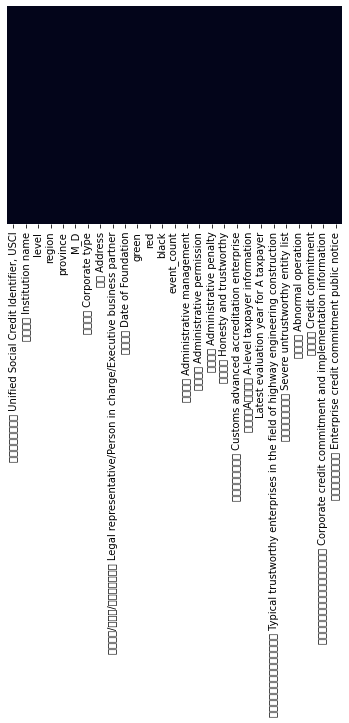

In [264]:
# check missing value
sns.heatmap(df_meta_m_new.isnull(),cbar=False,yticklabels=False)

In [265]:
# fill na in numbers
df_meta_m_new = df_meta_m_new.fillna(0)

In [281]:
df_plot_data = df_meta_m_new[['行政许可 Administrative permission',
    '行政处罚 Administrative penalty',
    '海关高级认证企业 Customs advanced accreditation enterprise',
    '纳税信用A级纳税人 A-level taxpayer information',
    '公路工程建设领域守信典型企业 Typical trustworthy enterprises in the field of highway engineering construction',
    '严重失信主体名单 Severe untrustworthy entity list',
    '经营异常 Abnormal operation',
    '企业信用承诺及其履约践诺情况信息 Corporate credit commitment and implementation information',
    '企业信用承诺公示 Enterprise credit commitment public notice',
                             'red', 'black']]
df_plot_data.columns = ['Admin permission',
    'Admin penalty',
    'Customs accreditation',
    'A-level taxpayer',
    'Trustworthy enterprises in highway construction',
    'Severe untrustworthy entity',
    'Abnormal operation',
    'Credit commitment and implementation',
    'Credit commitment public notice',
                             'red', 'black']

<AxesSubplot: >

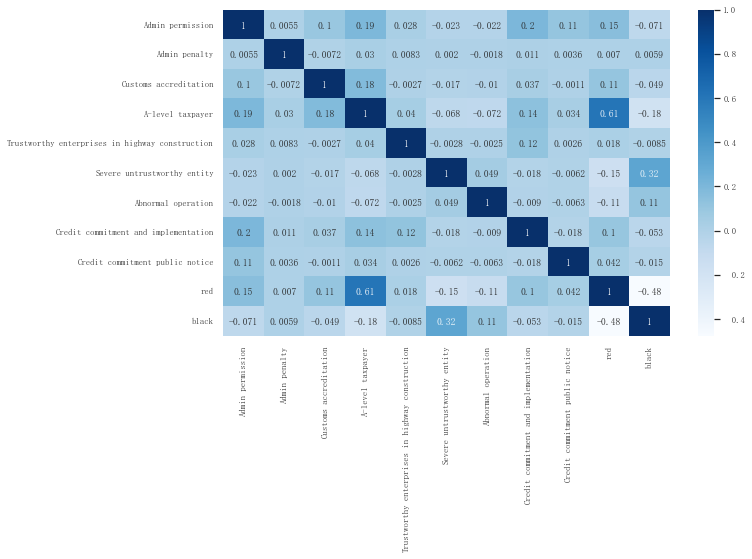

In [284]:
# check correlation
# Dark shades represents positive correlation while lighter shades represents negative correlation.
sns.set(font='SimSun', font_scale=0.8)

plt.figure(figsize=(10,6))
sns.heatmap(df_plot_data.corr(),cmap='Blues',annot=True) 

C:\Users\f-li\Miniconda3\envs\parsingpdf\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<AxesSubplot: >

C:\Users\f-li\Miniconda3\envs\parsingpdf\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\f-li\Miniconda3\envs\parsingpdf\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


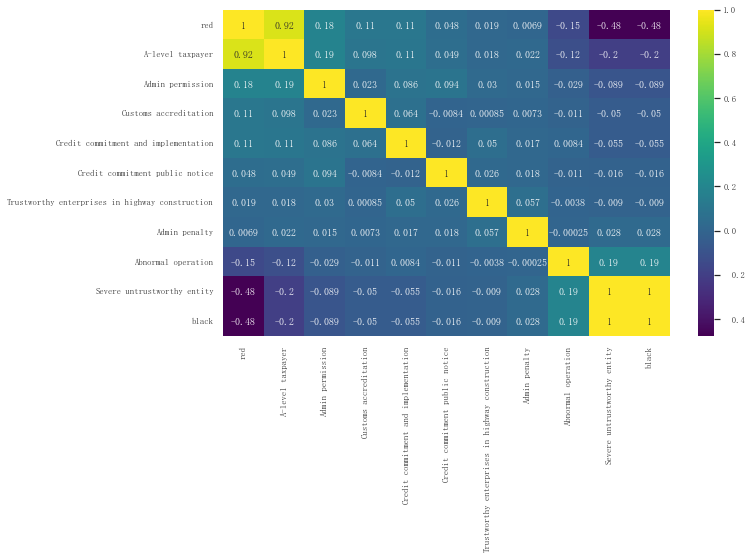

In [296]:
#Quality correlation matrix
# binary
df_plot_bi_data = df_plot_data.copy()
df_plot_bi_data[df_plot_bi_data > 0] = 1

k = 11 #number of variables for heatmap
#cols = df_plot_data.corr().nlargest(k, 'red')['red'].index
#cm = df_plot_data[cols].corr()
cols = df_plot_bi_data.corr().nlargest(k, 'red')['red'].index
cm = df_plot_bi_data[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')



C:\Users\f-li\AppData\Local\Temp/ipykernel_892/3334144177.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_plot_data['A-level taxpayer'], kde=True)


<AxesSubplot: xlabel='A-level taxpayer', ylabel='Density'>

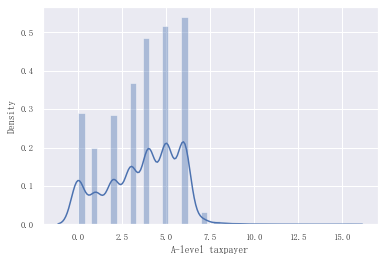

In [303]:
sns.distplot(df_plot_data['A-level taxpayer'], kde=True)

## event5

In [392]:
df_event_public.duplicated(keep=False).sum()

176

In [393]:
df_event_public[df_event_public.duplicated(keep=False)]

,统一社会信用代码 Unified Social Credit Identifier,company_name,信用承诺事项 Credit Commitment Matters,做出信用承诺时间 Time to make a credit commitment,经办人 Manager,year
0,91320200607984659Y,双良节能系统股份有限公司,物联网发展专项资金,2017-02-23,— —,2017
1,91320200607984659Y,双良节能系统股份有限公司,物联网发展专项资金,2018-06-15,— —,2018
2,91320200607984659Y,双良节能系统股份有限公司,物联网发展专项资金,2018-06-15,— —,2018
3,91320200607984659Y,双良节能系统股份有限公司,物联网发展专项资金,2017-02-23,— —,2017
5,91320200240507994H,天奇自动化工程股份有限公司,总部经济发展资金,2017-10-31,— —,2017
...,...,...,...,...,...,...
193,913202007333114202,美尚生态景观股份有限公司,绿化企业信用等级评价,2018-11-14,— —,2018
206,91320200733313338L,凯龙高科技股份有限公司,"承诺遵守劳动保障法律、法规及政策,规范用工",2018-11-01,— —,2018
207,91320200733313338L,凯龙高科技股份有限公司,"承诺遵守劳动保障法律、法规及政策,规范用工",2018-11-01,— —,2018
208,91320200733313338L,凯龙高科技股份有限公司,工业发展资金,2018-05-07,— —,2018


2018    119
2017     91
2011      1
Name: 做出信用承诺时间 Time to make a credit commitment, dtype: int64

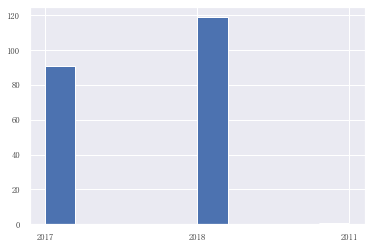

In [323]:
# sub-event 9
# remove the rows without data
df_tmp = df_event_public.drop(df_event_public[df_event_public['做出信用承诺时间 Time to make a credit commitment'] == '— —'].index)
year = df_tmp['做出信用承诺时间 Time to make a credit commitment'].str[:4]

# distribution of year
plt.hist(year)
year.value_counts()

In [394]:
df_event_implementation.duplicated().sum()

1354

In [395]:
df_event_implementation[df_event_implementation.duplicated(keep=False)]

,统一社会信用代码 Unified Social Credit Identifier,company_name,承诺类型 Commitment type,承诺事由 Commitment reason,做出承诺日期 Commitment date,承诺受理单位 Commitment processing unit,承诺履约状态 Commitment implementation status
34,914300006940434345,华自科技股份有限公司,主动型,公共资源交易事前信用承诺书,2020-11-30,武汉市政务服务和大数据管理局(武汉市公共资源交易监督管理局),— —
37,914300006940434345,华自科技股份有限公司,主动型,公共资源交易事前信用承诺书,2020-11-30,武汉市政务服务和大数据管理局(武汉市公共资源交易监督管理局),— —
43,91310000566558740F,华荣科技股份有限公司,主动型,自愿作出承诺,2020-09-17,兰州市公共资源交易中心,— —
46,91310000566558740F,华荣科技股份有限公司,主动型,自愿作出承诺,2020-09-17,兰州市公共资源交易中心,— —
49,91510300762306858F,华西能源工业股份有限公司,行业自律型,行业自律,2021-09-14,焦作市发展和改革委员会,— —
...,...,...,...,...,...,...,...
15727,91350200612046130C,华懋(厦门)新材料科技股份有限公司,审批替代型,外商投资企业设立及变更备案,2019-09-10,厦门市商务局,— —
15728,91350200612046130C,华懋(厦门)新材料科技股份有限公司,审批替代型,环境行政许可的信用承诺,2020-11-12,厦门市生态环境局,— —
15729,91350200612046130C,华懋(厦门)新材料科技股份有限公司,审批替代型,材料真实性声明,2018-03-01,厦门市工业和信息化局,— —
15758,91440300757618160G,华测检测认证集团股份有限公司,主动型,自愿作出承诺,2018-03-28,兰州市公共资源交易中心,— —


([<matplotlib.patches.Wedge at 0x1578db40d60>,
 [Text(-0.09126246323607104, 1.0962076275980226, '主动型'),
  Text(-0.45162324405260557, -1.0030136815773756, '审批替代型'),
  Text(0.8413642031592036, -0.7085945791792926, '证明事项型'),
  Text(1.0713661346166303, -0.2493483619288901, '行业自律型'),
  Text(1.0993317720270794, -0.03833607976569116, '信用修复型')])

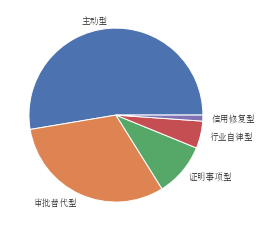

In [330]:
# sub-event8
t = df_event_implementation['承诺类型 Commitment type'].value_counts()
plt.pie(t, labels = t.index)

([<matplotlib.patches.Wedge at 0x1578dc60bb0>,
 [Text(0.1780049074375926, 1.0855018438160915, '2021'),
  Text(-1.0258404383699535, -0.39705339062264855, '2020'),
  Text(-0.2685133436814375, -1.066724230654303, '1970'),
  Text(0.2708500967309211, -1.0661333055021078, '2019'),
  Text(0.6675787874206826, -0.8742645838565871, '2018'),
  Text(0.8799503895314472, -0.6600661421126328, '2022'),
  Text(0.9765817159124832, -0.506249100883577, '2017'),
  Text(1.0252858666157632, -0.3984832389423219, '2016'),
  Text(1.0513298042639414, -0.3235825129180239, '2015'),
  Text(1.0615674221272722, -0.2882266612894409, '2014'),
  Text(1.0667242294758639, -0.26851334836302804, '2000'),
  Text(1.071067415843725, -0.25062839168347456, '2001'),
  Text(1.0750643938706228, -0.23288741707441052, '1998'),
  Text(1.0786388162457652, -0.21572738372291675, '1993'),
  Text(1.0817808419295198, -0.1993745471073467, '1999'),
  Text(1.0845654297461076, -0.18362415037146146, '2003'),
  Text(1.0870202230459245, -0.1684845

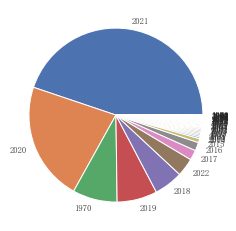

In [337]:
year = df_event_implementation['做出承诺日期 Commitment date'].str[:4].value_counts()
plt.pie(year, labels=year.index)

## event4

In [396]:
df_event4_m.duplicated().sum()

0

([<matplotlib.patches.Wedge at 0x157a3c9ce50>,
 [Text(0.10781885436251686, 1.0947031993394165, '2022'),
  Text(-0.9701133907831906, -0.5185364105085974, '2021'),
  Text(-0.10781885436251651, -1.0947031993394167, '2019'),
  Text(0.5185364105085973, -0.9701133907831906, '2018'),
  Text(0.9146165735327998, -0.6111272563215624, '2020'),
  Text(1.0526343693054299, -0.31931314497990876, '2016'),
  Text(1.0947031993394167, -0.10781885436251656, '2015')])

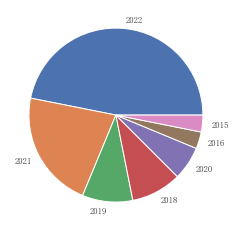

In [339]:
year = df_event4_m['设定日期 Establishment date'].str[:4].value_counts()
plt.pie(year, labels=year.index)

## event3

In [398]:
df_event3_m.duplicated(['案号 Case Number', '立案时间 Date of Filing', 'company_name']).sum()

0

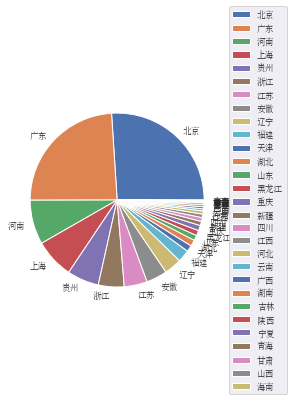

In [346]:
data = df_event3_m['省份  Province'].value_counts()
plt.pie(data, labels=data.index)
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))

([<matplotlib.patches.Wedge at 0x157a60accd0>,
 [Text(0.6214595583466763, 0.9076276865210504, '2020'),
  Text(-1.0688564220836883, 0.25989603492638447, '2021'),
  Text(-0.355661880890009, -1.0409152830474637, '2019'),
  Text(0.641655621373488, -0.8934640807328537, '2022'),
  Text(1.036111023605732, -0.3694238037304611, '2018'),
  Text(1.0871668619725396, -0.16753571030911987, '2017'),
  Text(1.0920523852949846, -0.1319908624546967, '2014'),
  Text(1.0951665903944527, -0.10300553035536025, '2015'),
  Text(1.0973585653955533, -0.07618516228907884, '2016'),
  Text(1.0986835897958256, -0.053799344915695636, '2013'),
  Text(1.0992594556302158, -0.04035652620780986, '2006'),
  Text(1.0995519972018701, -0.03139116833407907, '2011'),
  Text(1.099771420181075, -0.022423722993771173, '2012'),
  Text(1.0998879943787618, -0.015697127809415477, '2010'),
  Text(1.0999428541185494, -0.011212389287727264, '2005'),
  Text(1.0999794276363715, -0.006727464363409504, '2008'),
  Text(1.0999977143242037, -0

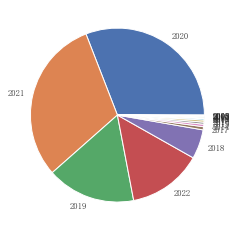

In [348]:
data = df_event3_m['立案时间 Date of Filing'].str[:4].value_counts()
plt.pie(data, labels=data.index)

In [359]:
behavior_type_list = []
for t in df_event3_m['失信被执行人行为具体情形 Person of Execution Untrustworthy Behavior Details'].unique():
    behavior_type_list.extend(t.split(','))

types = list(set(behavior_type_list))
types

['其他妨碍、抗拒执行',
 '有履行能力而拒不履行生效法律文书确定义务',
 '违反限制高消费令',
 '其他规避执行',
 '违反财产报告制度',
 '被执行人无正当理由拒不履行执行和解协议',
 '其他有履行能力而拒不履行生效法律文书确定义务',
 '转移财产规避执行']

In [361]:
df_event3_m['失信被执行人行为具体情形 Person of Execution Untrustworthy Behavior Details'] = df_event3_m['失信被执行人行为具体情形 Person of Execution Untrustworthy Behavior Details'].str.split(',')

# create 8 new columns
for t in types:
    df_event3_m[t] = 0

# set 1 if the row belong to the type
for i in df_event3_m.index:
    v = df_event3_m.loc[i, '失信被执行人行为具体情形 Person of Execution Untrustworthy Behavior Details']
    for t in types:
        if t in v:
            # set to 1
            df_event3_m.loc[i, t] = 1
            
t_x = []
t_y = []
for t in types:
    t_x.append(t)
    t_y.append(df_event3_m[t].sum())

其他妨碍、抗拒执行
32
有履行能力而拒不履行生效法律文书确定义务
980
违反限制高消费令
5
其他规避执行
120
违反财产报告制度
384
被执行人无正当理由拒不履行执行和解协议
42
其他有履行能力而拒不履行生效法律文书确定义务
24
转移财产规避执行
1


[Text(0, 0, '32'),
 Text(0, 0, '980'),
 Text(0, 0, '5'),
 Text(0, 0, '120'),
 Text(0, 0, '384'),
 Text(0, 0, '42'),
 Text(0, 0, '24'),
 Text(0, 0, '1')]

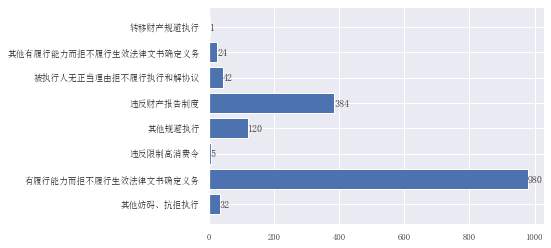

In [387]:
b = plt.barh(t_x, t_y)
plt.bar_label(b)

## event2

In [399]:
df_event_a_taxpayer.duplicated().sum()

5

In [400]:
df_event_a_taxpayer[df_event_a_taxpayer.duplicated(keep=False)]

,统一社会信用代码 Unified Social Credit Identifier,company_name,纳税人名称 Taxpayer name,纳税人识别号 Taxpayer ID,评价年度 Evaluation year,数据来源 Data sources
121,91320100134881640F,南京中央商场(集团)股份有限公司,南京中央商场(集团)股份有限公司,91320100134881640F,2017.0,国家税务总局
122,91320100134881640F,南京中央商场(集团)股份有限公司,南京中央商场(集团)股份有限公司,91320100134881640F,2017.0,国家税务总局
5003,91650100228584428B,新疆友好(集团)股份有限公司,新疆友好(集团)股份有限公司,91650100228584428B,2017.0,国家税务总局
5004,91650100228584428B,新疆友好(集团)股份有限公司,新疆友好(集团)股份有限公司,91650100228584428B,2017.0,国家税务总局
12412,91500102208507353E,重庆太极实业(集团)股份有限公司,重庆太极实业(集团)股份有限公司,91500102208507353E,2017.0,国家税务总局
12413,91500102208507353E,重庆太极实业(集团)股份有限公司,重庆太极实业(集团)股份有限公司,91500102208507353E,2017.0,国家税务总局
12717,91640000227693286K,银川新华百货商业集团股份有限公司,银川新华百货商业集团股份有限公司,91640000227693286K,2016.0,国家税务总局
12722,91640000227693286K,银川新华百货商业集团股份有限公司,银川新华百货商业集团股份有限公司,91640000227693286K,2016.0,国家税务总局
14381,91620000224336881T,兰州丽尚国潮实业集团股份有限公司,兰州民百(集团)股份有限公司,91620000224336881T,2017.0,国家税务总局
14382,91620000224336881T,兰州丽尚国潮实业集团股份有限公司,兰州民百(集团)股份有限公司,91620000224336881T,2017.0,国家税务总局


In [401]:
df_event_custom.duplicated().sum()

0

## event1

In [405]:
# penalty
df_event_penalty.duplicated().sum()

0

In [410]:
# change -- to 0
i = df_event_penalty[df_event_penalty['罚款金额(万元) Fine Amount, 10k Yuan']=='— —'].index
df_event_penalty.loc[i, '罚款金额(万元) Fine Amount, 10k Yuan'] = 0

i = df_event_penalty[df_event_penalty['没收违法所得、没收非法财物的金额（万元）Confiscation of Illegal Gains, 10k Yuan']=='— —'].index
df_event_penalty.loc[i, '没收违法所得、没收非法财物的金额（万元）Confiscation of Illegal Gains, 10k Yuan'] = 0

In [424]:
# prepare data for bar chart
x = []
y = []

# fine
df_event_penalty['罚款金额(万元) Fine Amount, 10k Yuan'] = df_event_penalty['罚款金额(万元) Fine Amount, 10k Yuan'].astype(float)
x.append('Fine amount')
y.append((df_event_penalty['罚款金额(万元) Fine Amount, 10k Yuan']>0).sum())

# confiscation
df_event_penalty['没收违法所得、没收非法财物的金额（万元）Confiscation of Illegal Gains, 10k Yuan'] = df_event_penalty['没收违法所得、没收非法财物的金额（万元）Confiscation of Illegal Gains, 10k Yuan'].astype(float)
x.append('Confiscation')
y.append((df_event_penalty['没收违法所得、没收非法财物的金额（万元）Confiscation of Illegal Gains, 10k Yuan']>0).sum())

# license
# TODO update for daughters
x.append('License')
y.append(3)

# others
other_s = df_event_penalty[(df_event_penalty['没收违法所得、没收非法财物的金额（万元）Confiscation of Illegal Gains, 10k Yuan'] 
                            == 0) & (df_event_penalty['罚款金额(万元) Fine Amount, 10k Yuan']== 0)]['处罚内容 Penalty Content']

print(other_s)
x.append('Others')
y.append(other_s.count() - 3) # TODO: split licensem, confiscation by code from others

9                                           暂扣安全生产许可证30天
10                                          暂扣安全生产许可证30天
11                                          暂扣安全生产许可证30天
116                                                   警告
191                                             责令停止违法行为
257    生产、销售不符合保障人体健康和人身、财产安全的国家标准、行业标准的产品的,责令停止生产、销售...
279               没收Y系列三相异步电动机Y225M-4型(编号:03553)等11台电动机。
323                                              不予行政处罚。
330                                          罚款人民币零元(0元)
336                                            违法事实不能成立。
337                                             警告&警告&警告
363                                              不予行政处罚。
Name: 处罚内容 Penalty Content, dtype: object


[Text(0, 0, '350'), Text(0, 0, '16'), Text(0, 0, '3'), Text(0, 0, '9')]

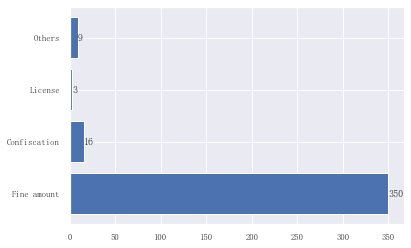

In [425]:
b = plt.barh(x, y)
plt.bar_label(b)

<AxesSubplot: >

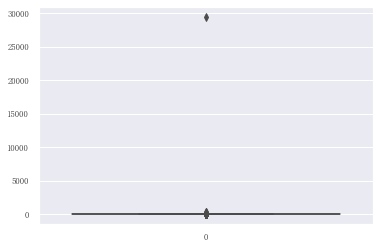

In [427]:
data = df_event_penalty[df_event_penalty['罚款金额(万元) Fine Amount, 10k Yuan']>0]['罚款金额(万元) Fine Amount, 10k Yuan']
sns.boxplot(data)

(0.0, 1.0)

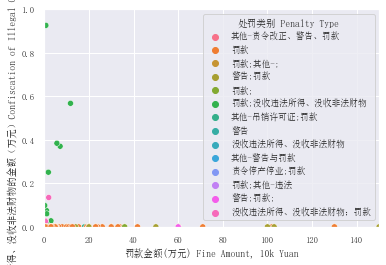

In [445]:
data = df_event_penalty[(df_event_penalty['没收违法所得、没收非法财物的金额（万元）Confiscation of Illegal Gains, 10k Yuan'] 
                            > 0) | (df_event_penalty['罚款金额(万元) Fine Amount, 10k Yuan']>0)]
sns.scatterplot(data, x='罚款金额(万元) Fine Amount, 10k Yuan', y=
                '没收违法所得、没收非法财物的金额（万元）Confiscation of Illegal Gains, 10k Yuan',
               hue='处罚类别 Penalty Type')
#plt.xlabel('Fine Amount, 10k Yuan')
#plt.ylabel('Confiscation of Illegal Gains, 10k Yuan')
plt.xlim(0, 150)
plt.ylim(0, 1)

Text(0.5, 1.0, 'decision date')

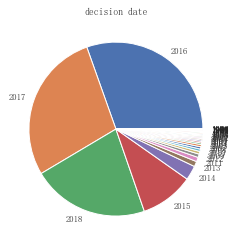

In [447]:
# permit old
year = df_event_permit_old['许可决定日期 Permission decision date'].str[:4].value_counts()
plt.pie(year, labels=year.index)
plt.title('decision date')

Text(0.5, 1.0, 'Audit type')

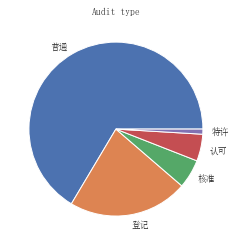

In [452]:
data = df_event_permit_old['审核类型 Audit Type'].value_counts()
plt.pie(data, labels=data.index)
plt.title('Audit type')

Text(0.5, 1.0, 'Type of Permission')

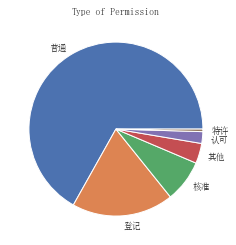

In [454]:
# permit new
data = df_event_permit_new['许可类别 Type of Permission']
data = data.str[:2].value_counts()
plt.pie(data, labels=data.index)
plt.title('Type of Permission')

Text(0.5, 1.0, 'Permission  Decision Valid From')

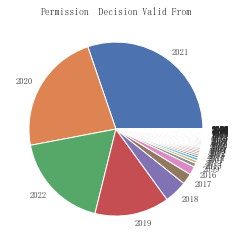

In [455]:
year = df_event_permit_new['有效期自 Permission  Decision Valid From'].str[:4].value_counts()
plt.pie(year, labels=year.index)
plt.title('Permission  Decision Valid From')

# 4. Category events